In [ ]:
# !pip install stuffs
!pip install tslearn
!pip3 install geopandas
!pip3 install Shapely
!pip3 install kneed
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

import os
import csv
import math
import zipfile
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import geopandas as gpd
import kneed
from shapely.geometry import Point
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score
# Algorithms
# from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.barycenters import softdtw_barycenter
from tslearn.clustering import TimeSeriesKMeans, KShape
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from zipfile import ZipFile
# Mount to nipchan@uscs.edu drive
# print(os.listdir())
from google.colab import drive
# drive.mount("/content/drive")
# print(os.listdir())
if "drive" in os.listdir():
    os.chdir("drive/MyDrive/MSMC-Curve-Analysis/") # Made a directory in home Drive called "data"
np.seterr(divide = "ignore")

### NEW SECTION ###

# Local clustering class with a bunch of methods
from numpy.ma.core import nonzero

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class Msmc_clustering():
    def __init__(self, 
                 directory, 
                 mu = None, 
                 generation_time_path = None, 
                 real_time = False, 
                 normalize_lambda = False, 
                 log_scale_time = False, 
                 plot_on_log_scale = False, 
                 uniform_ts_curve_domains=False, 
                 to_omit=[], 
                 exclude_subdirs=[], 
                 manual_cluster_count=False,
                 algo="kmeans"):
        # np.random.seed(31415) # Set constant random seed, could also use random_state when creating tslearn.clustering.TimeSeriesKMeans object
        # np.random.seed only works because all packages pretty much use it, next time use random_state
        '''
        Class for clustering MSMC Curves (Ne curves). Enables options for how to 
        filter/clean data, which metrics from MSMC curves to cluster on



        Inputs:
        1.) String of directory to read in. Should end with "/". 
        2.) Mutation rate used for MSMC files
        3.) Name of file containing used generation times for each MSMC file

        log_scale_time: If enabled, actual time column in series data is log10 scaled.
        - If plot_on_log_scale is also enabled with log_scale_time, x and y labels 
          should automatically match plots and plots should not forcibly convert
          x values to log scale.
          - plot_curve_clusters()
          - plot_curve()

        Object contains
        1.) Mutation rate used for msmc data
        2.) List of dataframes (series), where each df is data from a file in directory - from read_file
        3.) List of the names corresponding to each df (file in directory) - from read_file
        4.) Set of unique series lengths (Used for cleaning purposes/uniformity) - from read_file
        5.) List of series lengths (Used for cleaning purposes/uniformity) - from read_file
        6.) Int for number of files read in - from mySeries
        7.) List of clustering labels assigned to each file (Order specific, not good to sort)
        8.) Int of clustering categories

        '''
        self.manual_cluster_count = manual_cluster_count
        self.mu = mu # Possible that files use different mutation rates

        # In the future, just read these with a txt file or something
        self.subdir_class_dict = {
            "birds_part_1":"aves",
            "birds_part_2":"aves",
            "mammals_part_1":"mammals",
            "Archive":"mammals"
        }

        self.class_mu_dict = {
            "aves" : 1.4e-9,
            "mammals" : 2.2e-9
        }
        self.algo = algo

        self.subdir2file_dict = {subdir:[] for subdir in self.subdir_class_dict.keys()}

        

        self.gen_time_dict = self.read_gen_times(generation_time_path) # keys are latin names delim by "_" instead of " "
        self.real_time = real_time
        self.normalize_lambda = normalize_lambda # Either normalize lambda or make lambda on log10 scale
        if self.real_time:
            self.plot_on_log_scale = True
            self.log_scale_time = True
        else:
            self.plot_on_log_scale = plot_on_log_scale
            self.log_scale_time = log_scale_time 
            
        self.to_omit = to_omit # List of file names to omit
        # self.mySeries, self.namesofMySeries share the same order
        self.mySeries, self.namesofMySeries, self.series_lengths, self.series_lengths_lists = self.read_file(directory, real_time, exclude_subdirs)
        self.filter_data(uniform_ts_curve_domains)
        self.normalize()
        self.seriesDict = {name : self.mySeries[idx] for idx, name in enumerate(self.namesofMySeries)}
        # self.filter_data() # Call method to filter data
        
        self.lenMySeries = len(self.mySeries)
        # These None attributes are filled with sequential calls to PCA methods
        self.dtw_labels = None # Will be list of labels for how curves are clustered
        self.cluster_count = None
        self.clusterTable = None
        self.latin_names = None
        self.km = None
        self.elbow_data = None
        self.clustering_data = None # From cleanSeries arrays used for clustering 
        self.name2series = dict() # Dict important for mapping names to series, label,
        self.label2barycenter = None # Dict that is created when runing self.find_cluster_barycenters() after clustering 
        '''
        self.name2series:
        Important for mapping names to series. Particularly useful for grabbing
        data given a name, or given a list of names corresponding to a clustering 
        group.

        EX: 
        list_of_samples_of_label_1 = cluster_rt_norm_lenient.cluster_from_label(1)["Sample"]
        data_for_each_sample_of_label_1 = [self.name2series[name] for name in list_of_samples_of_label_1]
        '''
        
        if self.real_time:
            if self.normalize_lambda:
                if self.plot_on_log_scale:
                    self.suptitle = 'Effective Population Size Time Series'
                    self.xlabel = "Real Time in Years (log10)"
                    self.ylabel = "Effective Population Size (Normalized to [0, 1])"
                else:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years "
                    self.ylabel = "Effective Population Size (Normalized to [0, 1])"   
            else:
                if self.plot_on_log_scale:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years (log10)"
                    self.ylabel = "Effective Population Size (1E4)"
                else:
                    self.suptitle = 'Effective Population Size Time Series Curves'
                    self.xlabel = "Real Time in Years "
                    self.ylabel = "Effective Population Size (1E4)"   
        else:
            self.suptitle = 'Coalescence Rate Time Series Curves'
            self.xlabel = "Scaled Time (left_time_boundary)"
            self.ylabel = "Scaled Coalescence Rate (lambda)"

    def read_file(self, directory, real_time, exclude_subdirs = []):
        '''
        Assuming that given directory contains subdirs full of separate MSMC curves,
        go through each subdir in directory and read each file in subdir as a pd.df.

        each subdir may have a specific mu or generation time

        Input:
        1.) String of directory to read in. Should end with "/". 

        Outputs:
        1.) List of dataframes (series)
        2.) List of the names corresponding to each df 
        3.) Set of unique series lengths 
        4.) List of series lengths
        '''
        mySeries = []
        namesofMySeries = []
        # print(self.to_omit)
        for subdir in os.listdir(directory): # There is an assumption that each subdir has its own mu since each subdir has corresponded to a single tax-class
        # Dependence of my on assumption that files in a subdir are of the same class can be circumvented if I just have a mapping between filenames and tax-classes
            # print(subdir+"/")
            if subdir not in exclude_subdirs:
                for filename in os.listdir(directory+subdir+"/"): # depending on filename's taxanomical class, mu may vary
                    if filename.endswith(".txt"):
                        if filename[:-4] not in self.to_omit:
                            # print(directory+subdir+"/"+filename)
                            df = pd.read_csv(directory+subdir+"/"+filename, sep='\t')
                            # While we are at it I just filtered the columns that we will be working on
                            df.set_index("time_index",inplace=True)
                            # set the date columns as index
                            df.sort_index(inplace=True)
                            # and lastly, ordered the data according to our date index
                            mySeries.append(df)
                            namesofMySeries.append(filename[:-4])
                            self.subdir2file_dict[subdir].append(filename)
                            if real_time: # If real time curves are desired, transform current df
                                mu = self.class_mu_dict[self.subdir_class_dict[subdir]] # Index into my convoluted ass dictionaries to get mu's for subsets of data
                                # mu = self.mu # How things originally were when I was converting curves from only aves from B10K
                                # Convert scaled time to real time
                                df["left_time_boundary"] = df["left_time_boundary"]/mu # Convert to generations
                                for key in self.gen_time_dict.keys(): # Step can be improved if keys list is sorted
                                    if key in filename:
                                        generation_time = self.gen_time_dict[key]
                                        df["left_time_boundary"] = df["left_time_boundary"] * generation_time
                                # Convert Coalescence Rate to Ne
                                df["lambda"] = 1/df["lambda"] # Take inverse of coalescence rate
                                df["lambda"] = df["lambda"]/(2*mu)

        series_lengths = {len(series) for series in mySeries} # Compile unique Series lengths
        series_lengths_list = [len(series) for series in mySeries] # Compile unique Series length
        return mySeries, namesofMySeries, series_lengths, series_lengths_list

    def read_gen_times(self, directory: "str") -> "dict":
        '''
        Possibly better to read generation times data after reading in MSMC curves
        whenever number taxa generation times > ts curves available

        For each file in directory, reads in a two column txt file and returns a dict where keys are 
        sample-taxa name and values are generation times (years/generation) used
        for generating MSMC curves for each sample-taxa. Strong assumption that
        1st col is for sample-taxa names and 2nd col is for generation times

        Dict use:
        If file name has a dict key within it, use that key's value as a generation 
        time
        '''
        if directory:
            gen_time_dict = dict()
            genLenFile = os.listdir(directory)
            for glf in genLenFile:
                fileLen = 0
                duplicateEntries = 0
                with open(directory+glf, "r") as myfile:
                    next(myfile) # Assuming that first line in generation times file are labels
                    for idx, line in enumerate(myfile):
                        pair = line.split("\t")
                        # print(pair)
                        key = pair[0] # taxa name
                        val = float(pair[1]) # generation time
                        gen_time_dict[key] = val
                        fileLen += 1
                        if fileLen - len(list(gen_time_dict.keys())) > duplicateEntries:
                            print(f"Duplicate gen time entry for taxa: {key} at line {idx}")
                            duplicateEntries += 1
                    print(f"fileLen: {fileLen}\nduplicate entries: {duplicateEntries}")
            return gen_time_dict
        else:
            return None



    def filter_data(self, uniform_ts_curve_domains=False):
        '''
        First part takes in a group of series and scales their time ranges to 
        the series with the oldest date.

        Inputs:
        1.) Set of unique series lengths
        2.) List of series lengths 
        3.) Option for scaling 
        '''
        # Record sizes and lengths of series'
        # if scaled_to_real: # Scale data to real time and eff. pop. sizes

        # Only use series' of the longest known length
        max_series_len = max(self.series_lengths)

        newMySeries = []
        newNamesOfMySeries = []
        for idx, series in enumerate(self.mySeries):
            if len(series) == max_series_len:
                if series["left_time_boundary"].iloc[0] == 0: # If 1st time entry is 0

                    # print(f"len of trimmed df: {len(series.iloc[1:])}")
                    newMySeries.append(series.iloc[1:]) # Clip off 1st entry to avoid -inf err when scaling to log10 scale in normalize()
                    # Entry at 0th and 1st idx are identical for lambda so no meaningful info should be lost
                else:
                    newMySeries.append(series)
                newNamesOfMySeries.append(self.namesofMySeries[idx])
        self.mySeries = newMySeries
        self.namesofMySeries = newNamesOfMySeries
        
        # Find largest final time plotted among series
        # Make sure all series' are on the range of the series of the largest size (biggest final time recorded on X-axis)
        # This should be fine since all times boundaries are implied to end on inf anyways (found in original data)

        if uniform_ts_curve_domains:
            ts_beginning_time = {series["left_time_boundary"].max() for series in self.mySeries} # units in terms of max(series) (Time)
            ts_beginning_time = max(ts_beginning_time)
            to_extend_idxs = [] # Record series' which had final recorded times less that biggest final time
            for i in range(len(self.mySeries)):
                if max(self.mySeries[i]) != ts_beginning_time: # If series doesn't extend to oldest time series beginning time
                    to_extend_idxs.append(i)
            for idx in to_extend_idxs: # Scale time boundaries of each series to the oldest known one in all data
                self.mySeries[idx]["left_time_boundary"].iloc[-1] = ts_beginning_time

    def normalize_series(self, series: "pd.series") -> "pd.series":
        '''
        Normalize a pandas series (df or col) to [0, 1]
        '''
        # print("Normalizing")
        return (series - series.min())/(series.max() - series.min())

    def normalize(self):
        '''
        Transform time column into log10 scale [BAD]
            - Due to use of DTW, using a log10 transform exponentially decreases
              the difference (time) between data points as ts curve will be in terms
              of magnitude rather than time
            - Instead, maybe forget about log10 transform except when it comes to plotting
        Don't 
        and either
        (1) Normalize lambda column to [0, 1]
        (2) Divide lambda column by 1e4
        '''
        for idx in range(len(self.mySeries)):
            if self.log_scale_time:
                self.plot_on_log_scale = True  
                self.mySeries[idx]["left_time_boundary"] = np.log10(self.mySeries[idx]["left_time_boundary"])
            if self.normalize_lambda:
                self.mySeries[idx]["lambda"] = self.normalize_series(self.mySeries[idx]["lambda"])
            else:
                pass

    def plot_series(self, num_to_plot=None, cols=5, fs_x=50, fs_y=25):
        '''
        Plots curves for mySeries dfs as they are in current object. By default
        mySeries dfs may only be in terms of Scaled time and Coalescence Rate

        Inputs:
        1.) Int of plots to make
        2.) Int of columns for figure
        '''
        if not num_to_plot: # If no number of plots is specified
            num_to_plot = self.lenMySeries # Number of plots to plot is set to the number of files read in
        # rows = (num_to_plot//cols) + 1 # Find number of rows for figure
        if num_to_plot%cols > 0:
            rows = (num_to_plot//cols) + 1 # Find number of rows for figure
        else:
            rows = (num_to_plot//cols)
        fig, axs = plt.subplots(rows, cols, figsize=(fs_x, fs_y)) # MPL subplot
        fig.suptitle(self.suptitle) # Figure super title

        for i in range(rows):
            for j in range(cols):
                if i*cols+j+1 > len(self.mySeries): # pass the others that we can't fill
                    continue
                curr = self.mySeries[i*cols+j]
                x_list = curr.left_time_boundary.to_numpy()
                y_list = curr["lambda"].to_numpy()
                axs[i, j].step(x_list, y_list, 'g-', where="pre")
                axs[i, j].set_title(self.namesofMySeries[i*cols+j])  
                axs[i, j].set_xlabel(self.xlabel) # time
                axs[i, j].set_ylabel(self.ylabel) # size
        fig.patch.set_facecolor('white') # Changes background to white
        plt.show()

    def elbow_method(self, random_state=205, gamma=None, save_name="cluster-related-figures/elbow-method-plot.png", plot=False, low=2, high=20, save_to=None):
        '''

        Usage ex: 
        save_to = "MSMC-Exploratory-Analysis/results/figures/"
        instance.elbow_method(save_to=save_to)
        '''
        fig = plt.figure()
        plt.suptitle(f"gamma = {gamma}")
        elbow_data = []
        cleanSeries = [series.drop(["right_time_boundary"], axis=1) for series in self.mySeries]
        for n_clusters in range (low, high+1):
            if not gamma is None:
                print(f"soft-DTW gamma = {gamma}")
                if self.algo == "kmeans":
                    print(f"gamma = {gamma}")
                    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, 
                                          metric="softdtw", 
                                          metric_params={"gamma": gamma}, 
                                          dtw_inertia=True, 
                                          random_state=random_state)
                elif self.algo == "kshapes":
                    km = KShape(n_clusters=n_clusters, verbose=False, 
                                random_state=random_state) 
                else:
                    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, 
                                          metric="softdtw", 
                                          metric_params={"gamma": gamma}, 
                                          dtw_inertia=True, 
                                          random_state=random_state)
            else:
                print("DTW")
                if self.algo == "kmeans":
                    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, 
                                          metric="dtw", dtw_inertia=True, 
                                          random_state=random_state)
                elif self.algo == "kshapes":
                    km = KShape(n_clusters=n_clusters, verbose=False, 
                                random_state=random_state) 
                else:
                    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, 
                                          metric="dtw", dtw_inertia=True, 
                                          random_state=random_state)
            y_pred = km.fit_predict(cleanSeries)
            elbow_data.append((n_clusters, km.inertia_))
        ax = pd.DataFrame(elbow_data, columns=['clusters', 'distance']).plot(x='clusters', y='distance')
        self.elbow_data = elbow_data
        ax.set_ylabel("Distortion in Sum of squared distances (Inertia)")
        if save_to:
            plt.savefig(save_to + save_name, dpi=300)
        plt.show()
        return 

    def compute_cluster_barycenter(self, label:"int", iter:"int"=5, gamma=None):
        '''
        Returns barycenter of a computed cluster as two lists: x, y
        '''
        
        data = []
        names = self.cluster_from_label(label)["Sample"].tolist()
        for name in names:
            data.append(self.name2series[name].drop(["right_time_boundary"], axis=1).to_numpy())
        if not gamma is None and not gamma == 0.0:
            barycenter = softdtw_barycenter(data, max_iter=5, gamma=gamma)
        else:
            barycenter = dtw_barycenter_averaging(data, max_iter=5)
        x, y = zip(*barycenter)
        return x, y

    def find_cluster_barycenters(self, iter:"int"=5, gamma=None):
        '''
        Acts with self.compute_cluster_barycenter()
        '''
        label2barycenter = dict()
        for label in set(self.dtw_labels): # self.dtw_labels computed after clustering, only using the set of labels though, so might just want to use the range(clusternumber)
            label2barycenter[label] = self.compute_cluster_barycenter(label, iter, gamma)
        return label2barycenter

    def cluster_curves(self, train_iter=200, random_state=205, 
                       uniform_ts_curve_domains=False, omit_front=0, 
                       omit_back=0, cols=3, fs_x=25, fs_y=50, save_to=None, 
                       metric="dtw", 
                       save_name="cluster-related-figures/curve-clusters.png", 
                       omit_time_feature=False, metric_params={"gamma": None}, 
                       iter=5, plot_everything=True):        
        '''
        MAIN FUNCTION TO CALL FOR PLOTTING. Calls other methods to function.

        Clusters dataframes with K means using DTW.
        Plots dataframe curves (MSMC curves) within their assigned clusters.
        Plots 2 PCA scatterplots comparing how 
        1.) K means using DTW 
        2.) K means using
        clustered dataframe curves (MSMC curves)
        '''
        # Form a list of dfs to cluster
        if metric_params["gamma"] == 0.0: # By default do this b/c tslearn has a divide by 0 err o.w.
            metric = 'dtw'
        cleanSeries_with_df = [series.drop(["right_time_boundary"], axis=1) for series in self.mySeries] # List of dfs with only the desired 2 columns


        print(f"cleanSeries_with_df: {len(cleanSeries_with_df)},")
        print(f"mySeries: {len(self.mySeries)}")
        print(f"mySeries: {len(self.mySeries[0])}")

        cleanSeries_with_df = [series[omit_front: max(self.series_lengths) - omit_back] for series in cleanSeries_with_df] # Omit certain number of datapoints from front (end time) and back (beginning time) of ts curve
        cleanSeries = np.array(cleanSeries_with_df)
        # After checking how clusters are formed when omitting time data, worse clusters will form
        if omit_time_feature: # Enable only if you want to exclude time interval info from clustering
            cleanSeries = cleanSeries[:,:,1] 
        print(f"Plotting {len(cleanSeries[0])}/{max(self.series_lengths)}")
        print(f"Omitting {omit_front} points from front and {omit_back} from back")
        if self.manual_cluster_count:
            self.cluster_count = self.manual_cluster_count
        else:
            self.cluster_count = math.ceil(math.sqrt(len(cleanSeries)))
        # Cluster using dtw 
        print(self.algo, metric)
        if self.algo == "kmeans":
            if metric == "softdtw":
                self.km = TimeSeriesKMeans(n_clusters=self.cluster_count, 
                                    verbose=False, 
                                    metric="softdtw", 
                                    metric_params=metric_params, 
                                    dtw_inertia=True, 
                                    random_state=random_state,
                                    max_iter=train_iter)
            elif metric == "dtw":
                self.km = TimeSeriesKMeans(n_clusters=self.cluster_count, 
                                    verbose=False, 
                                    metric="dtw", 
                                    dtw_inertia=True, 
                                    random_state=random_state,
                                    max_iter=train_iter)    
 
            print(type(self.km))
        # Fit/train model
        self.dtw_labels = self.km.fit_predict(cleanSeries) # km.fit_predict is fit on a 2 column df (BEWARE OF NON UNIFORM SERIES')
        # Make table mapping names to labels
        self.clusterTable = {self.namesofMySeries[i] : self.dtw_labels[i] for i in range(len(self.dtw_labels))}
        print(f"sample len: {len(self.namesofMySeries)}")
        print(f"label len: {len(self.dtw_labels)}")
        data = {"Sample": self.namesofMySeries, "Labels": self.dtw_labels}
        self.clusterTable = pd.DataFrame.from_dict(data, orient="columns")
        self.add_latin_to_cluster()
        self.clustering_data = cleanSeries_with_df
        for idx, name in enumerate(self.namesofMySeries):
            self.name2series[name] = self.mySeries[idx] # Compute some cluster barycenters
        gamma = metric_params["gamma"]
        self.label2barycenter = self.find_cluster_barycenters(iter, gamma)
        # Plots curves within their assigned clusters
        if plot_everything:
            self.plot_curve_clusters(cleanSeries_with_df, cols, fs_x, fs_y, 
                                    save_to = save_to, 
                                    metric_params=metric_params, 
                                    save_name = save_name) 
            # Plots distribution of curves among the clusters created with dtw
            self.plot_cluster_distr(save_to=save_to, 
                                    save_name = "distr_" + save_name)

        


    def plot_curve_clusters(self, cleanSeries,  cols=3, fs_x=25, fs_y=50, save_to = None, iter=5, metric_params={"gamma": None}, save_name="cluster-related-figures/curve-clusters.png"):
        '''
        Plots curves within their clusters assigned from K means using DTW

        Dark Grey region is Last Glacial Period
        Light Grey region is Pleistocene
        '''
        # Necessary for plotting figure subplots (square shape), nothing else
        # plot_count = math.ceil(math.sqrt(self.cluster_count)) 
        num_to_plot = self.cluster_count # Set no. plots to the no. of clusters
        print(f"num to plot : {num_to_plot}")
        if num_to_plot%cols == 0:
            rows = (num_to_plot//cols)
        else:
            rows = (num_to_plot//cols) + 1
        print(f"curve cluster plot shape: ({rows}, {cols})")
        fig, axs = plt.subplots(rows, cols, figsize=(fs_x, fs_y))
        if self.algo == "kmeans":
            if metric_params["gamma"] is None:
                fig.suptitle(f'DTW Clusters of {self.suptitle}\nK = {self.cluster_count}')
            else:
                fig.suptitle(f'soft-DTW Clusters of {self.suptitle}\n{metric_params}, K = {self.cluster_count}')
        else:
            fig.suptitle(f'{self.algo} Clusters of {self.suptitle}')
        plt.rcParams["figure.facecolor"] = 'white'

        row_i=0
        column_j=0
        # Plot curves with their cluster according to their label
        for idx_l, label in enumerate(set(self.dtw_labels)): # For each unique/possible label
            x_cluster = []
            y_cluster = []
            for i in range(len(self.dtw_labels)): # For each curve's label
                    if self.dtw_labels[i]==label: # match it to the current unique/possible label focused on
                        if self.plot_on_log_scale and not self.log_scale_time:
                            x = np.log10(cleanSeries[i]["left_time_boundary"].to_numpy()) # Index mySeries for df
                        else:
                            x = cleanSeries[i]["left_time_boundary"].to_numpy()
                        y = cleanSeries[i]["lambda"].to_numpy()


                        # Curve color assignment
                        if self.namesofMySeries[i]+".txt" in self.subdir2file_dict["Archive"]: # Color Archive files differently (mammals)
                            reg_curve_color = "green" 
                        elif self.namesofMySeries[i]+".txt" in self.subdir2file_dict["birds_part_2"]:
                            reg_curve_color = "gray" 
                        elif self.namesofMySeries[i]+".txt" in self.subdir2file_dict["birds_part_1"]:
                            reg_curve_color = "gray" 
                        else:
                            reg_curve_color = "gray" 

                        if rows == 1: # If axs only takes 1D indices
                            axs[column_j].step(x, y, "+-", c=reg_curve_color, alpha=0.4)
                            
                        else:
                            axs[row_i, column_j].step(x, y, "+-", c=reg_curve_color,alpha=0.4)
                        x_cluster.append(x)
                        y_cluster.append(y)
            if len(x_cluster) > 0:
                # X = dtw_barycenter_averaging(x_cluster, y_cluster)
                x_avg = np.average(x_cluster, axis=0)
                y_avg = np.average(y_cluster, axis=0)
                y_sd = np.std(y_cluster, axis=0)

                if rows == 1: # If axs only takes 1D indices

                    axs[column_j].step(x_avg ,y_avg, "+--",    c="magenta", alpha=0.4, label="Arithmetic mean") # Arithemtic avg of curves plotted in magenta
                    axs[column_j].step(x_avg ,y_avg-y_sd, "+--", c="blue", alpha=0.4, label="Arithmetic SD Lower") 
                    axs[column_j].step(x_avg ,y_avg+y_sd, "+--", c="blue", alpha=0.4, label="Arithmetic SD Upper") 
                    # Plot cluster centroid
                    center_series = self.km.cluster_centers_[idx_l]
                    x_center = [i[0] for i in center_series]
                    y_center = [i[1] for i in center_series]
                    axs[column_j].step(x_center, y_center, "+--", c="orange", alpha=0.6, label="Cluster Centroid")
                    # Plot cluster barycenter
                    x_barycenter, y_barycenter = self.label2barycenter[idx_l]
                    axs[column_j].step(x_barycenter, y_barycenter, "+-", c="red", alpha=1, label="Cluster Barycenter")

                    # axs[column_j].step(xs, ys, "+-", label="DTW Barycentric avg") # DBA line which DTW uses as centroids for clustering
                    axs[column_j].set_title("Cluster "+ str(column_j + (row_i*cols)) )
                    axs[column_j].set_xlabel(self.xlabel)
                    axs[column_j].set_ylabel(self.ylabel)
                    if self.real_time: # Here is where to edit for differentiating curves by color
                        axs[column_j].axvspan(4, 5, alpha=0.5, color='grey')
                        axs[column_j].axvspan(5, 6.3, alpha=0.25, color='grey')
                        # axs[column_j].set_xlim(4, 7.5)
                else: 
                    axs[row_i, column_j].step(x_avg ,y_avg, "+--",    c="magenta", alpha=0.4, label="Arithmetic mean") # Arithemtic avg of curves plotted in magenta
                    axs[row_i, column_j].step(x_avg ,y_avg-y_sd, "+--", c="blue", alpha=0.4, label="Arithmetic SD Lower") 
                    axs[row_i, column_j].step(x_avg ,y_avg+y_sd, "+--", c="blue", alpha=0.4, label="Arithmetic SD Upper") 
                    # Plot cluster center
                    center_series = self.km.cluster_centers_[idx_l]
                    x_center = [i[0] for i in center_series]
                    y_center = [i[1] for i in center_series]
                    axs[row_i, column_j].step(x_center, y_center, "+--", c="orange", alpha=0.6, label="Cluster Centroid")
                    # Plot cluster barycenter
                    x_barycenter, y_barycenter = self.label2barycenter[idx_l]
                    axs[row_i, column_j].step(x_barycenter, y_barycenter, "+-", c="red", alpha=1, label="Cluster Barycenter")

                    # axs[row_i, column_j].step(xs, ys, "+-", c="red", label="DTW Barycentric avg") # DBA line which DTW uses as centroids for clustering
                    axs[row_i, column_j].set_title("Cluster "+ str(column_j + (row_i*cols)) )
                    axs[row_i, column_j].set_xlabel(self.xlabel)
                    axs[row_i, column_j].set_ylabel(self.ylabel)
                    if self.real_time:
                        axs[row_i, column_j].axvspan(4, 5, alpha=0.5, color='grey')
                        axs[row_i, column_j].axvspan(5, 6.3, alpha=0.25, color='grey')
                        # axs[row_i, column_j].set_xlim(4, 7.5)
            
            column_j+=1 # Increment subplot column
            if column_j == cols:
                row_i+=1
                column_j=0
        if save_to:
            plt.savefig(save_to + save_name, dpi = 300)
        plt.show()

    def plot_cluster_distr(self, save_to=None, save_name="curve-clusters.png"):
        '''
        Plots histogram to illustrate distribution of curves among the clusters 
        created with dtw
        '''
        cluster_c = [len(self.dtw_labels[self.dtw_labels==i]) for i in range(self.cluster_count)]
        cluster_n = ["Cluster "+str(i) for i in range(self.cluster_count)]
        plt.figure(figsize=(15,5))
        plt.title(f"Cluster Distribution for {self.algo}")
        plt.bar(cluster_n,cluster_c)
        if save_to:
            plt.savefig(save_to + save_name, dpi = 100)
        plt.show()

    def plot_PCA(self, cleanSeries, labels=False):
        '''
        Plots a PCA scatterplot with either regular K means labels or 
        K means labels using DTW.
        '''
        pca = PCA(n_components=2) # sklearn.decomposition PCA 
        X = [series["left_time_boundary"] for series in cleanSeries]
        Y = [series["lambda"] for series in cleanSeries]
        cleanSeries_transformed = pca.fit_transform(X, Y) # Performs PCA
        kmeans = KMeans(n_clusters=self.cluster_count, max_iter=5000) # sklearn.cluster KMeans 
        if not labels: 
            labels = kmeans.fit_predict(cleanSeries_transformed) # Computes PCA labels with sklearn.cluster KMeans
        else:
            labels = self.dtw_labels # Use curve clusters from k means with DTW
        
        plt.figure(figsize=(20, 5))
        plt.title(f"PCA of MSMC Curves (labels={labels})")
        plt.scatter(cleanSeries_transformed[:, 0], cleanSeries_transformed[:, 1], c=labels, s=300)
        plt.show()

    def plot_curve(self, name=None, df = None, dir = None, dups=0, stretch=0, err=0, thresh_min=None, thresh_max=None, winStart=None, winEnd=None, fs_x=10, fs_y=10, xlim_start=None, xlim_end=None, ylim_start=None, ylim_end=None,  save_to = None, additional_info=None, plot_on_log_scale=True):
        '''
        Plots series curve given name, df, or dir of series
        Option to save plot to a directory
        '''
        # plt.rcParams["figure.facecolor"] = 'white'
        plt.figure(figsize=(fs_x, fs_y))

        if xlim_start and xlim_end:
            plt.xlim(xlim_start, xlim_end)
        if ylim_start and ylim_end:
            plt.ylim(ylim_start, ylim_end)
        

        if name:
            idx = self.namesofMySeries.index(name)
            series = self.mySeries[idx]
        elif dir:
            df = pd.read_csv(dir, sep='\t')
            # While we are at it I just filtered the columns that we will be working on
            df.set_index("time_index",inplace=True)
            # set the date columns as index
            df.sort_index(inplace=True)
            name = dir[:dir.index(".txt")]
            series = df
        else:
            series = df

        if plot_on_log_scale and not self.log_scale_time:
            x = np.log10(series["left_time_boundary"].to_numpy()) # Index mySeries for df
            # if winStart and winEnd:
            #     winStart = np.log10(winStart)
            #     winEnd = np.log10(winEnd)
        else:
            x = series["left_time_boundary"].to_numpy()
        y = series["lambda"].to_numpy()
        plt.axvspan(4, 5, alpha=0.5, color='grey')
        plt.axvspan(5, 6.3, alpha=0.25, color='grey')
        plt.step(x, y, "+-", c="green")
        if thresh_min and thresh_max:
            plt.plot(x, [thresh_min]*len(x), "-", color="salmon")
            plt.plot(x, [thresh_max]*len(x), "--", color="red")
            
        if winStart and winEnd:
            plt.axvline(x = winStart, color="magenta", linestyle="-")
            plt.axvline(x = winEnd, color="purple", linestyle="--")
        if additional_info:
            title = f"{name} \n{dups*100:.2f}% of curve is flat.  Curve flatness threshold: >={stretch*100:.2f}%\nUsing {err*100}% error"
            for string in additional_info:
                title += string + "\n"
            plt.title(title)
        else:
            plt.title(f"{name} \n{dups*100:.2f}% of curve is flat.  Curve flatness threshold: >={stretch*100:.2f}%\nUsing {err*100}% error")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        # plt.show()
        if save_to:
            plt.savefig(fname=f"{save_to}/{name}.png", dpi=300)
        plt.show()

    def list_from_cluster(self, num, omit=False):
        '''
        Return a list which either keeps or omits the names of the files of cluster
        corresponding to given {num } 
        '''
        if not omit:
            boolList = [True if i == num else False for i in self.clusterTable["Labels"].tolist()]
        else:
            boolList = [False if i == num else True for i in self.clusterTable["Labels"].tolist()]
        return self.clusterTable[boolList]["Sample"].tolist()

    def cluster_from_label(self, label: "int") -> "df":
        '''
        Retrieve a single cluster from self.clusterTable as a df given a label
        '''
        boolList = (self.clusterTable["Labels"] == label).tolist()
        return self.clusterTable.iloc[boolList]

    def series_from_name(self, name):
        idx = self.namesofMySeries.index(name)
        return self.mySeries[idx]

    def add_latin_to_cluster(self):
        '''
        Adds latin names column to cluster table in order to get some sort of relational
        identifier between it and the meta data table
        Table matcher only works if original MSMC curve files had their corresponding
        GCA accession ID in their name. However this loop only uses GCA accession ID to 
        throw it out, so GCA isn't really needed to accomplish the goal of confering 
        df_meta entries over to associated clusterTable entries. It's just the simplest 
        and most efficient way to do it right now, unless I can somehow add GCA accession
        ID to the 
        '''
        latin_name_list = []
        for sample_name in self.clusterTable["Sample"]:
            try:
                cutoff_idx = sample_name.index("_GCA") # Bad, but working way to separate 
            except:
                cutoff_idx = sample_name.index("_GCF") # Bad, but working way to separate 
            latin_name = sample_name[:cutoff_idx]
            latin_name_list.append(latin_name)
        self.clusterTable["Latin name"] = pd.Series(latin_name_list)
        self.latin_names = self.clusterTable["Latin name"].tolist()
        self.clusterTable = self.clusterTable.set_index("Latin name")
        return

### NEW SECTION ###
# Load in precomputed list of files to filter out (Saves time)

# Consider making the sharpness filter on percent too
regular_path = "lenient-curve-filter"
filter_path = "MSMC-Exploratory-Analysis/results/figures/filtered-out-curves"
kept_path = "MSMC-Exploratory-Analysis/results/figures/kept-curves"

omit_list_path = "MSMC-Exploratory-Analysis/results/lists"
omit_test_lenient_file = "omit_test_lenient.txt"
kept_test_lenient_file = "kept_test_lenient.txt"

if omit_test_lenient_file not in os.listdir(omit_list_path):
    omit_test_lenient = filter_flattness_sharpness(cluster_rt, 
                        identical_val_threshold = 0.7, err = 0.01, # Args for filtering flattness
                        magnitude_jump_threshold = 0.95, points_per_jump = 3, # Args for filtering magnitude jumps
                        plot = True, min_unique_vals=999, ignore_low_mag=0, 
                        fs_x=10, fs_y=9, save_to_filter=filter_path, save_to_kept=kept_path) # These are some pretty good settings
    with open(omit_list_path+"/"+omit_test_lenient_file, "w") as myFile:
        for fileName in omit_test_lenient:
            myFile.write(f"{fileName}\n")

else: # If list exists
    omit_test_lenient = [] # List of names to files which were filtered out due to being elboq shaped
    with open(omit_list_path+"/"+omit_test_lenient_file, "r") as myFile:
        for line in myFile:
            omit_test_lenient.append(line.rstrip())

kept_test_lenient = [] # List of names to files which were kept
for jpg_name in os.listdir(kept_path):
    jpg_name = jpg_name[:-4] # assuming that all files in "kept_path" are .jpgs and end with the specifier ".jpg"
    kept_test_lenient.append(jpg_name)

# List of latin names is useful for indexing on metadata dfs later on
omit_test_lenient_latin = [name[:name.index("_GC")] for name in omit_test_lenient] 
kept_test_lenient_latin = [name[:name.index("_GC")] for name in kept_test_lenient]


### NEW SECTION ###
# import stuff for silhouette analysis, REQUIRED for next code block
from tslearn.generators import random_walks
from tslearn.metrics import cdist_dtw, cdist_soft_dtw_normalized
from sklearn.metrics import silhouette_samples as sklearn_silhouette_samples
from sklearn.metrics import silhouette_score as sklearn_silhouette_score
from tslearn.clustering import silhouette_score
from tslearn.utils import to_time_series_dataset, to_time_series
import matplotlib.cm as cm
import json 

def bootleg_silhouette_samples(X, labels, metric=None, sample_size=None,
                     metric_params=None, n_jobs=None, verbose=0,
                     random_state=None, **kwds):
    '''
    Basically the same as how tslearn made silhouette_score i.e. by computing
    a list of pairwise distances I think.
    '''
    sklearn_metric = None
    if metric_params is None:
        metric_params_ = {}
    else:
        metric_params_ = metric_params.copy()
    for k in kwds.keys():
        metric_params_[k] = kwds[k]
    if "n_jobs" in metric_params_.keys():
        del metric_params_["n_jobs"]
    if metric == "precomputed":
        sklearn_X = X
    elif metric == "dtw" or metric is None:
        sklearn_X = cdist_dtw(X, n_jobs=n_jobs, verbose=verbose,
                              **metric_params_)
    elif metric == "softdtw":
        sklearn_X = cdist_soft_dtw_normalized(X, **metric_params_)
    elif metric == "euclidean":
        X_ = to_time_series_dataset(X)
        X_ = X_.reshape((X.shape[0], -1))
        sklearn_X = cdist(X_, X_, metric="euclidean")
    else:
        X_ = to_time_series_dataset(X)
        n, sz, d = X_.shape
        sklearn_X = X_.reshape((n, -1))

        def sklearn_metric(x, y):
            return metric(to_time_series(x.reshape((sz, d)),
                                         remove_nans=True),
                          to_time_series(y.reshape((sz, d)),
                                         remove_nans=True))
    metric = "precomputed" if sklearn_metric is None else sklearn_metric
    return sklearn_silhouette_samples(X=sklearn_X,
                              labels=labels,
                              metric=metric,
                              sample_size=sample_size,
                              random_state=random_state,
                              **kwds)

def plot_sample_silhouette_spectrum(sample_silhouette_values, clusternum:'int', save_to=False, save_name=False):
    y_lower = 10
    for i in range(clusternum): # iterate over current num of clusters 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / clusternum)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=avg_silhouette_score, color="red", linestyle="--")
    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    if save_to:
        plt.savefig(fname=save_to + save_name, dpi = 300)

# Silhouette score clustering scheme test
- Cell block will compute a bunch of stuff and take a bit of time to finish
- Nested for loop O(gamma * clusternum)

In [ ]:
'''
Silhouette score clustering scheme test

Description:
Script aids in finding optimal cluster size and gamma to use for clustering based 
on silhouette scores. 

Notes:
Silhouette scores are on the range of [-1, 1] when -1 
is bad and 1 is good. Good silhouette scores reflect high between cluster separation
(high between group sum of squares) and high cluster cohesion (low bwithingn group 
sum of squares). 

Outline of program:
Script below runs clustering based on Soft-DTW with varying Gamma (soft-DTW parameter) 
and Cluster Sizes ( O(G*C) complexity ). Takes a long time to run so be patient.
'''



# path for output
silhouette_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"
# init a dict keyed by gamma-cluster number combos. Dict to be filled in from nested for loop below
avg_silhouette_score_dict = dict()
# Lists to iterate over
gammas = list(np.arange(1, 10, 1))
# gammas = np.array([0.0])
clusternums = list(range(2,21))

for gamma in gammas: # Iterate over gammas
    if gamma == 0.0:
        gamma_val = None
        metric_params={"gamma" : gamma_val} # tslearn soft-dtw  needs gamma param in this format
        print(metric_params, gamma)
    else:
        gamma = gamma.round(1) # Round to overcome dumb floating point error with numpy
        metric_params={"gamma" : gamma} # tslearn soft-dtw  needs gamma param in this format
    curr_gamma_dir = f"gamma_{gamma}" # Set current gamma as a name to be used for output path
    # Part 1 of handling directories for output; Specific to gamma
    fig_gamma_path = silhouette_path + "figures/" + curr_gamma_dir # Cluster Fig path
    list_gamma_path = silhouette_path + "lists/" + curr_gamma_dir # Cluster label List/table path
    if curr_gamma_dir not in os.listdir(silhouette_path + "figures/"): # mkdir for figures corresponding to current gamma
        os.mkdir(fig_gamma_path)
    if curr_gamma_dir not in os.listdir(silhouette_path + "lists/"): # mkdir for lists corresponding to current gamma
        os.mkdir(list_gamma_path)
    for clusternum in clusternums:
    # for clusternum in range(2, 10):
        curr_clusternum_dir = f"clusternum_{clusternum}"
        save_name = f"{curr_gamma_dir}_{curr_clusternum_dir}"
        # Part 2 of handling directories for output; Specific to gamma AND clusternum
        fig_path = fig_gamma_path + '/' + curr_clusternum_dir + '/' # Path specific to gamma AND cluster num
        list_path = list_gamma_path  + '/' + curr_clusternum_dir + '/'
        if curr_clusternum_dir not in os.listdir(fig_gamma_path): # mkdir for figures corresponding to current gamma
            os.mkdir(fig_path)
        if curr_clusternum_dir not in os.listdir(list_gamma_path):
            os.mkdir(list_path)

        # print("init")
        cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
                                                mu=1.4e-9, 
                                                generation_time_path='generation_lengths/', 
                                                real_time=True, 
                                                to_omit=omit_test_lenient, 
                                                normalize_lambda=True, 
                                                log_scale_time=True, 
                                                plot_on_log_scale=True, 
                                                exclude_subdirs=["Archive", "mammals_part_1"], 
                                                manual_cluster_count=clusternum) # cluster count by sqrt method is 14
        # Perform clustering and save fig
        print("clustering now")
        print("fig_path", fig_path)
        print("save_name", save_name)
        # Below code decides number of rows to achieve a 16:7 picture ratio
        cols = 4
        if clusternum%cols == 0:
            rows = (clusternum//cols)
        else:
            rows = (clusternum//cols) + 1
        fs_x = 64
        fs_y = 7 * rows
        if gamma > 0:
            metric = "soft-dtw"
        else:
            metric = "dtw"
        cluster_rt_norm_lenient.cluster_curves(omit_front=0, 
                                            omit_back=0, 
                                            cols=4,  
                                            fs_x=fs_x, 
                                            fs_y=fs_y, 
                                            metric_params=metric_params,
                                            save_to = fig_path,
                                            save_name = save_name+".png",
                                            metric = metric)
        
        # Save clustering model
        if save_name + ".hdf5" in os.listdir(list_path): # Attempt to overwrite if exists by manually deleting
            os.remove(list_path+save_name + ".hdf5")
            cluster_rt_norm_lenient.km.to_hdf5(list_path+save_name + ".hdf5")
        else:
            cluster_rt_norm_lenient.km.to_hdf5(list_path+save_name + ".hdf5")
        # Save clustering centers to numpy saved file .npy
        np.save(list_path+save_name + "_cluster_centers.npy", cluster_rt_norm_lenient.km.cluster_centers_)
        # Save clustering barycenters to numpy saved file .npy
        barycenters = []
        barycenters_final = []
        for idx, ts in cluster_rt_norm_lenient.label2barycenter.items():
            barycenters.append([idx, ts])
        for pair in barycenters:
            label = pair[0]
            xy = list(zip(pair[1][0], pair[1][1]))
            barycenters_final.append([label, np.array(xy)])
        barycenters_final = np.array(barycenters_final) # np.array (clusternum, 2), each clusternum is row is a pair of [clusternum, timeseries]
        np.save(list_path+save_name + "_cluster_barycenters.npy", barycenters_final)
        # Save curve-cluster table
        cluster_rt_norm_lenient.clusterTable.to_csv(list_path + save_name + ".tsv", sep="\t")
        X = np.array([i.drop("right_time_boundary", axis=1).to_numpy() for i in cluster_rt_norm_lenient.mySeries])
        labels = cluster_rt_norm_lenient.dtw_labels
        # Some sort of custom normalization done by tslearn (mod of sklearn silhouette score)
        # which generalizes dimension of X data
        avg_silhouette_score = silhouette_score(X, labels, metric = metric) 
        sample_silhouette_values = bootleg_silhouette_samples(X, labels, metric = metric)
        print(f"avg_silhouette_score = {avg_silhouette_score}")
        # Plot sample silhouette spectrum for current clustering
        plot_sample_silhouette_spectrum(sample_silhouette_values, clusternum, save_to=fig_path, save_name=save_name+"_sample_silhouette.png" )
        # Save sample silhoutte spectrum data
        X_names = [i for i in cluster_rt_norm_lenient.namesofMySeries]

        sample_silhouette_csvfile = list_path + save_name + "_sample_silhouette_scores.csv"
        with open(sample_silhouette_csvfile, 'w') as mf:
            for idx in range(len(X_names)):
                mf.write(f"{X_names[idx]},{labels[idx]},{sample_silhouette_values[idx]}\n")

        key = f"g{gamma} c{clusternum}"
        avg_silhouette_score_dict[key] = avg_silhouette_score
# Save avg_silhouette_score_dict as csv
import csv
csvfile = "avg_silhouette_scores.csv"
# csvfile = "avg_silhouette_scores.csv"
with open(silhouette_path + csvfile, 'w') as f:
    for key in avg_silhouette_score_dict.keys():
        f.write(f"{key},{avg_silhouette_score_dict[key]}\n")

{'gamma': None} 0.0
fileLen: 11126
duplicate entries: 0
fileLen: 5427
duplicate entries: 0


KeyboardInterrupt: ignored

# Silhouette Score Heatmap


Text(0.5, 1.0, 'Silhoutte Scores over Cluster Number and Gamma')

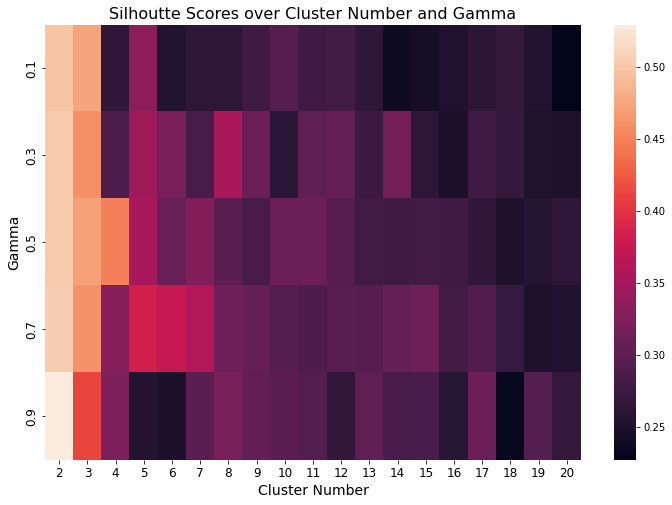

In [ ]:
'''
Script generates heatmap for silhouette scores for clustering settings

might want to run clustering on sizes 2-9 with gamma 0.1-0.9 in steps of 0.2
for fuller picture of silhouette landscape
'''
# Read clustering data (Silhouette scores)
silhouette_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"
csvfile = "avg_silhouette_scores.csv"
with open(silhouette_path + csvfile, 'r') as myfile:
    df_dict = dict()
    df_cols = set()
    for line in myfile:
        key_str, val_str = line.split(",")
        X_idx_g, Y_idx_c = key_str.split(" ")
        gamma = float(X_idx_g[1:])
        clustnum = int(Y_idx_c[1:])
        if gamma not in df_dict:
            df_dict[gamma] = []
        df_dict[gamma].append(float(val_str))
        df_cols.add(clustnum)
# Create pandas df for sns heatmap input
df_silhouettes = pd.DataFrame(df_dict.values(),columns=df_cols,index=df_dict.keys()).sort_index() 
# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_silhouettes)
plt.tick_params(axis='both',labelsize=12)
ax.set_xlabel("Cluster Number", fontsize=14)
ax.set_ylabel("Gamma", fontsize=14)
ax.set_title("Silhoutte Scores over Cluster Number and Gamma", fontsize=16)

# Elbow method tests
- Cell block will compute a bunch of stuff and take a bit of time to finish
- For each gamma, runs elbow method on cluster numbers 2-20

fileLen: 11126
duplicate entries: 0
fileLen: 5427
duplicate entries: 0
clustering now
fig_path MSMC-Exploratory-Analysis/results/silhouette-tests/figures/
save_name gamma_0.0_elbow_plot.png
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW
DTW


<Figure size 432x288 with 0 Axes>

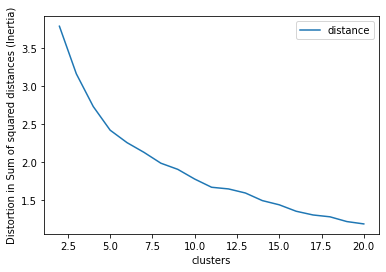

In [ ]:
'''
Elbow Method tests over gammas
'''

gammas = np.around(np.arange(.1, .91, 0.2), 1).tolist()
gammas = np.array([0.0])

elbow_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"

# Part 1 of handling directories for output
fig_path = elbow_path + "figures/" # Cluster Fig path
list_path = elbow_path + "lists/" # Cluster label List/table path

for gamma in gammas:
    curr_clusternum_dir = f"gamma_{gamma}"
    save_name = f"gamma_{gamma}_elbow_plot.png"
    save_name_csv = f"gamma_{gamma}_elbow_plot_data.csv"
    cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
                                            mu=1.4e-9, 
                                            generation_time_path='generation_lengths/', 
                                            real_time=True, 
                                            to_omit=omit_test_lenient, 
                                            normalize_lambda=True, 
                                            log_scale_time=True, 
                                            plot_on_log_scale=True, 
                                            exclude_subdirs=["Archive", "mammals_part_1"]) # cluster count by sqrt method is 14
    # Perform clustering and save fig
    print("clustering now")
    print("fig_path", fig_path)
    print("save_name", save_name)
    if gamma == 0.0:
        gammaval = None
    else:
        gamma = gammaval
    cluster_rt_norm_lenient.elbow_method(gamma=gammaval, save_name = save_name, save_to = fig_path + curr_clusternum_dir + "/")
    df = pd.DataFrame(cluster_rt_norm_lenient.elbow_data, columns = ['n_clusters', 'inertia']) # save this way bc im lazy
    df.to_csv(list_path + curr_clusternum_dir + "/" + save_name_csv)

# Elbow + Silhouette Score Method
- Makes use of a knee finding algo to find knees in elbow curves
- Uses the Elbow curve knees as a lower bound since the Elbow method indicates the point where most change stops

In [ ]:
main_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/"


# gammas = np.array([0.0])
# gamma = 0.1
# Elbow data gathering
list_path = main_path + "lists/"
# Example path to an elbow plot of gamma_0.1 over cluster numbers 2-19:
# elbow_path = main_path + "lists/gamma_0.1/gamma_0.1_elbow_plot_data.csv"
elbow_df_name = "elbow_inertia_scores.csv"
if elbow_df_name not in os.listdir(main_path):
    elbow_data = []
    gammas = os.listdir(list_path)
    # print(gammas)
    for gamma in gammas: # gamma will be a str f"gamma_{x}" where x is a gamma value
        gamma_value = gamma.split("_")[1] # String slicey time
        elbow_path = list_path + f"gamma_{gamma_value}/gamma_{gamma_value}_elbow_plot_data.csv"
        elbow_data.append(pd.read_csv(elbow_path))
    cluster_nums = elbow_data[0].drop('Unnamed: 0', axis=1).to_numpy()[:,0].tolist() # Retrieve cluster numbers from any elbow dataset
    cluster_nums = [f"cnum_{x}" for x in cluster_nums]
    # Construct a df where rows are gamma, cols are cluster numbers, and vals are inertias
    # os.listdir(list_path)
    elbow_df = pd.DataFrame(columns=cluster_nums, index = gammas) # (gammas, cluster_numbers) with vals = inertias
    for idx, data in enumerate(elbow_data):
        elbow_df.loc[gammas[idx]] = elbow_data[idx]["inertia"].to_numpy()
    elbow_df.to_csv(main_path + elbow_df_name)
else:
    elbow_df = pd.read_csv(main_path + elbow_df_name, index_col=0)
    cluster_nums = elbow_df.columns.to_list() # Retrieve cluster numbers from any elbow dataset


# Silhouette data gathering 
gammas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
silhouette_data_path = main_path + "avg_silhouette_scores.csv"
silhouette_df_name = "silhouette_scores.csv"
if silhouette_df_name not in os.listdir(main_path):
    silhouette_data = pd.read_csv(silhouette_data_path, header=None)  # data in csv is dim ~ (gammas, cluster_nums)
    gamma_names = [f"gamma_{gamma}" for gamma in gammas]
    silhouette_df = pd.DataFrame(columns=cluster_nums, index = gamma_names)
    # Code to "nicify" original icky silhouette score data 
    cg = silhouette_data[0].to_list() # gamma keys
    ss = silhouette_data[1].to_list() # cnum keys
    for idx, cg_entry in enumerate(cg):
        gamma, cnum = cg_entry.split(" ")
        gamma = gamma.replace("g", "gamma_")
        cnum = cnum.replace("c", "cnum_")+".0"
        silhouette_df[cnum].loc[gamma] = ss[idx]
    silhouette_df.to_csv(main_path + silhouette_df_name)
else:
    silhouette_df = pd.read_csv(main_path + silhouette_df_name, index_col=0)


8
10
8
10
8
10


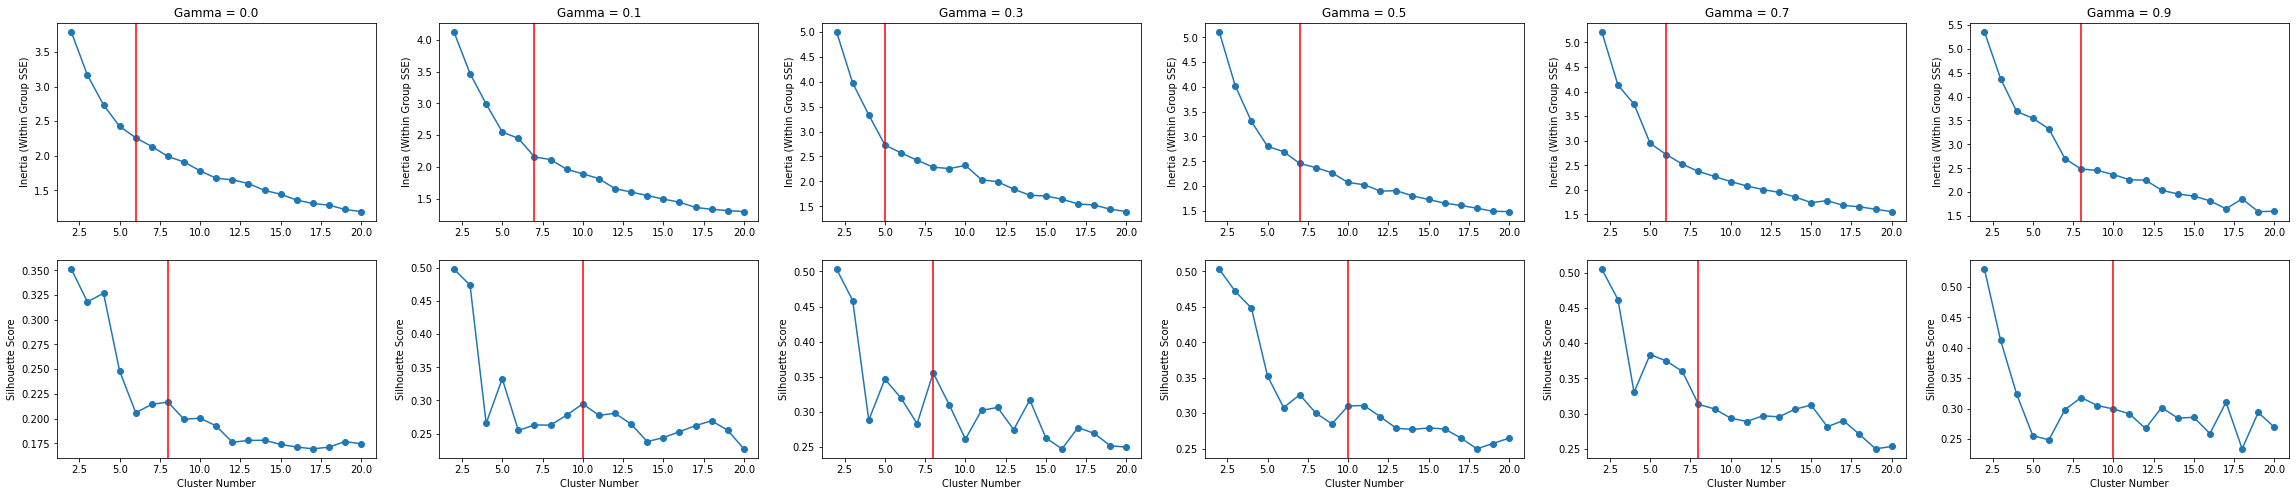

In [ ]:
'''
My proposal, we:
(1) Use Elbow method to find the cluster number where changes begin to drop off
(2) Then we use Silhouette Score to fine tune our selection as we should be choosing the cluster number which maximizes Sil. Score
    - Sil. Scores are really high with small cluster numbers though, likely because of the nature of the shapes of time series data

Ref.
[1] kneed package https://pypi.org/project/kneed/
[2] Deciding with Elbow, Eval with Silhoette https://towardsdatascience.com/silhouette-or-elbow-that-is-the-question-a1dda4fb974
[3] Roles of Elbow and Silhouettes https://vitalflux.com/elbow-method-silhouette-score-which-better/#:~:text=The%20elbow%20method%20is%20used,cluster%20or%20across%20different%20clusters.
'''


gammas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
fig, axs = plt.subplots(nrows = 2, ncols = 6, figsize=(40,8))
for col, gamma in enumerate(gammas):
    # Rely on elbow to choose the left boundary
    # Find Elbow knee point
    x = np.arange(2,21,1)
    y_elbow = elbow_df.loc[f"gamma_{gamma}"].to_numpy()
    kneedle_elbow = kneed.KneeLocator(x, y_elbow, S=1.0, curve="convex", direction="decreasing")
    # kneedle_elbow.plot_knee_normalized() # Helps visualize changes between points
    knee_point_elbow = kneedle_elbow.knee #elbow_point = kneedle.elbow
    axs[0][col].set_title(f"Gamma = {gamma}")
    axs[0][col].plot(x, y_elbow, "-o")
    axs[0][col].set_ylabel("Inertia (Within Group SSE)")
    axs[0][col].axvline(x = knee_point_elbow, color = 'r', label = 'axvline - full height')

    # Find Silhouette knee point
    y_silhouette = silhouette_df.loc[f"gamma_{gamma}"].to_numpy()
    kneedle_silhouette = kneed.KneeLocator(x[knee_point_elbow:], y_silhouette[knee_point_elbow:], S=1.0, curve="concave", direction="increasing")
    # kneedle_silhouette.plot_knee_normalized() # Helps visualize changes between points
    # Plot Silhouette
    knee_point_silhouette = kneedle_silhouette.knee #silhouette_point = kneedle.silhouette
    print(knee_point_silho?uette)
    axs[1][col].plot(np.arange(2,21,1), y_silhouette, "-o")
    axs[1][col].axvline(x = knee_point_silhouette, color = 'r', label = 'axvline - full height')
    axs[1][col].set_ylabel("Silhouette Score")
    axs[1][col].set_xlabel("Cluster Number")

elbow_fig_path = "MSMC-Exploratory-Analysis/results/silhouette-tests/figures/"
fig.savefig(elbow_fig_path + "Elbow+Silhouette_overview.png", dpi=300)

In [ ]:
'''
Reliability testing:

Runs a comparison with 30 random seeds
'''
# np.random.randint(1000, size=30)

from sklearn.metrics import adjusted_rand_score

# gammas = [6,7,8, 9]
gammas = [0.0]
clusts = [7,8,9,10,11,12,13,14]
seeds = seeds = [810, 564, 588, 155,  72]
# seeds = [810, 564, 588, 155,  72, 396, 738, 611,  29, 815, 762,  44, 133,
#        420, 520]
# seeds = [810, 564, 588, 155,  72, 396, 738, 611,  29, 815, 762,  44, 133,
#        420, 520, 222, 386, 235,  95, 167, 527,   5, 504, 876, 371, 172,
#        807, 948, 153, 775]

by_gamma_dict = dict() # Contains [old_seed_dict, new_seed_dict, randi_dict]
# clusts = list(range(5, 20))
for gamma in gammas:
    old_seed_dict = {clust : [] for clust in clusts}
    new_seed_dict = {clust : [] for clust in clusts}
    randi_dict =    {clust : [] for clust in clusts}
    for clust in clusts:
        cluster_rt_norm_lenient_og = Msmc_clustering(directory="msmc_curve_data/", 
                                                mu=1.4e-9, 
                                                generation_time_path='generation_lengths/', 
                                                real_time=True, 
                                                to_omit=omit_test_lenient, 
                                                normalize_lambda=True, 
                                                log_scale_time=True, 
                                                plot_on_log_scale=True, 
                                                exclude_subdirs=["Archive", "mammals_part_1"], 
                                                manual_cluster_count=clust,
                                                algo="kmeans") # cluster count by sqrt method is 14
        cluster_rt_norm_lenient_og.cluster_curves(omit_front=5, 
                                            omit_back=5, 
                                            cols=4,  
                                            fs_x=60, 
                                            fs_y=30,
                                            metric_params={"gamma" : gamma},
                                            metric="dtw")
        for seed in seeds:
            cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
                                                    mu=1.4e-9, 
                                                    generation_time_path='generation_lengths/', 
                                                    real_time=True, 
                                                    to_omit=omit_test_lenient, 
                                                    normalize_lambda=True, 
                                                    log_scale_time=True, 
                                                    plot_on_log_scale=True, 
                                                    exclude_subdirs=["Archive", "mammals_part_1"], 
                                                    manual_cluster_count=clust,
                                                    algo="kmeans",
                                                    ) # cluster count by sqrt method is 14

            cluster_rt_norm_lenient.cluster_curves(omit_front=5, 
                                                omit_back=5, 
                                                cols=4,  
                                                fs_x=60, 
                                                fs_y=30,
                                                metric_params={"gamma" : gamma},
                                                metric="dtw",
                                                random_state=seed,
                                                plot_everything=False)

            old = cluster_rt_norm_lenient_og.dtw_labels
            old_seed_dict[clust].append(old)

            new = cluster_rt_norm_lenient.dtw_labels
            new_seed_dict[clust].append(new)

            randi_dict[clust].append(adjusted_rand_score(old, new))
            
            from sklearn.metrics import adjusted_rand_score
            print(f"Random seed comparison of {clust} clusters: {adjusted_rand_score(old, new)}")
    by_gamma_dict[gamma] = [old_seed_dict, new_seed_dict, randi_dict]

Output hidden; open in https://colab.research.google.com to view.

In [1]:
# Save dict cuz it be large
import pickle
import json 

pname = "ri_test_gammas_0_0_f5b5.pickle"
dict_path = "MSMC-Exploratory-Analysis/results/"
with open(dict_path + pname, 'wb') as fp:
    pickle.dump(by_gamma_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

by_gamma_dict_slim = {gamma : by_gamma_dict[gamma][2] for gamma in gammas}
fname = "ri_test_gammas_0_0_f5b5_slim.json"
with open(dict_path + fname, 'w') as fp:
    json.dump(by_gamma_dict_slim, fp)

gammas = [0.0]
clustnums = [7,8,9,10,11,12,13,14]
fig, axs = plt.subplots(2,1, figsize=(12, 10))
fig.tight_layout(pad=5.0)
for gamma in gammas:
    randi_dict = by_gamma_dict_slim[gamma]
    # clustnums_ints = sorted([int(i) for i in randi_dict.keys()])
    # clustnums = sorted(list(randi_dict.keys()))
    avg_randi = [np.mean(randi_dict[clustnum]) for clustnum in clustnums]
    sd_randi =  [np.std(randi_dict[clustnum]) for clustnum in clustnums]
    var_randi = [np.var(randi_dict[clustnum]) for clustnum in clustnums]
    axs[0].set_title("Average Rand Index (5 trials each)")
    axs[0].set_xlabel("Cluster Number"                    )
    axs[0].set_ylabel("Average Rand Index Score"          )
    
    axs[0].plot(clustnums, avg_randi, '-o', label=f"Gamma = {gamma}")
    
    axs[0].legend()

    axs[1].set_title("Rand Index SD"    )
    axs[1].set_xlabel("Cluster Number"  )
    axs[1].set_ylabel("Rand Index Score")
    # axs[1].tick_params(fontsize=15)
    axs[1].plot(sd_randi, '-o', label=f"Gamma = {gamma}")
    axs[1].legend()

    # axs[2].set_title("Rand Index Var")
    # axs[2].set_xlabel("Cluster Number")
    # axs[2].set_xticks(clusts)
    # axs[2].set_ylabel("Rand Index Score")
    # axs[2].plot(var_randi, '-o', label=f"Gamma = {gamma}")
    # axs[2].legend()


NameError: ignored

In [ ]:
by_gamma_dict

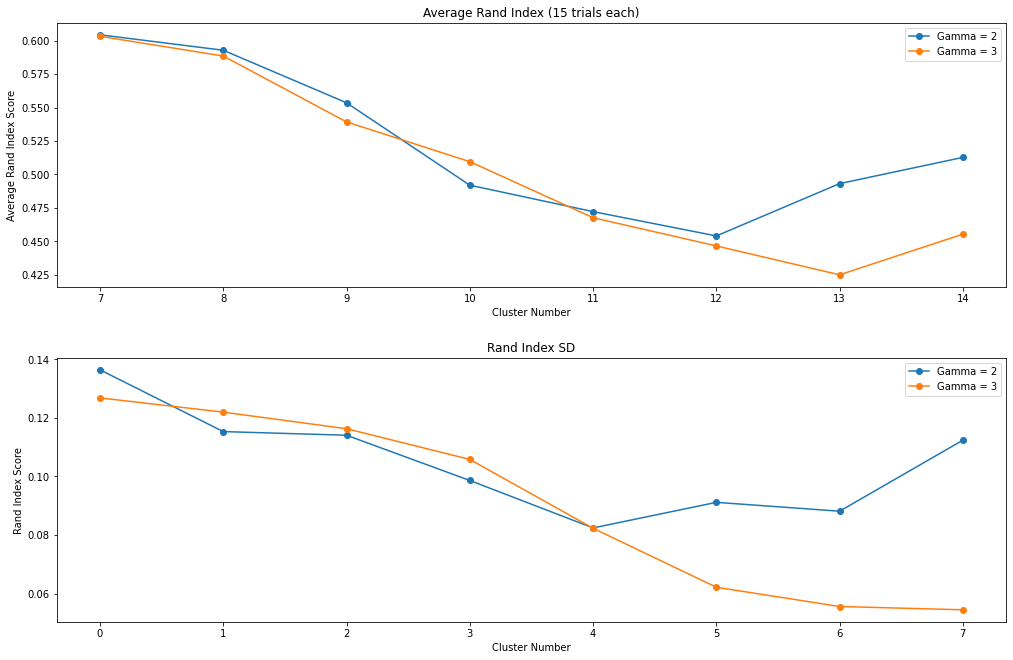

In [ ]:
gammas = [2, 3]
clustnums = [7,8,9,10,11,12,13,14]
fig, axs = plt.subplots(2,1, figsize=(15, 10))
fig.tight_layout(pad=5.0)
for gamma in gammas:
    randi_dict = by_gamma_dict_slim[gamma]
    # clustnums_ints = sorted([int(i) for i in randi_dict.keys()])
    # clustnums = sorted(list(randi_dict.keys()))
    avg_randi = [np.mean(randi_dict[clustnum]) for clustnum in clustnums]
    sd_randi =  [np.std(randi_dict[clustnum]) for clustnum in clustnums]
    var_randi = [np.var(randi_dict[clustnum]) for clustnum in clustnums]
    axs[0].set_title("Average Rand Index (15 trials each)")
    axs[0].set_xlabel("Cluster Number"                    )
    axs[0].set_ylabel("Average Rand Index Score"          )
    
    axs[0].plot(clustnums, avg_randi, '-o', label=f"Gamma = {gamma}")
    
    axs[0].legend()

    axs[1].set_title("Rand Index SD"    )
    axs[1].set_xlabel("Cluster Number"  )
    axs[1].set_ylabel("Rand Index Score")
    # axs[1].tick_params(fontsize=15)
    axs[1].plot(sd_randi, '-o', label=f"Gamma = {gamma}")
    axs[1].legend()

    # axs[2].set_title("Rand Index Var")
    # axs[2].set_xlabel("Cluster Number")
    # axs[2].set_xticks(clusts)
    # axs[2].set_ylabel("Rand Index Score")
    # axs[2].plot(var_randi, '-o', label=f"Gamma = {gamma}")
    # axs[2].legend()


# Results from comparisons of clustering seeds

### Comparing seeds of 205 and 42 for cluster sizes 5-20
```
cluster number: 5, rand index: 0.6858703145365873
cluster number: 6, rand index: 0.44519242169612916
cluster number: 7, rand index: 0.4996524346964769
cluster number: 8, rand index: 0.3902533924469417
cluster number: 9, rand index: 0.3761723359516322
cluster number: 10, rand index: 0.39530147166372603
cluster number: 11, rand index: 0.4460920554945721
cluster number: 12, rand index: 0.44112043144658336
cluster number: 13, rand index: 0.5657596990192374
cluster number: 14, rand index: 0.6014508139556152
cluster number: 15, rand index: 0.5171198409667344
cluster number: 16, rand index: 0.5278005668113127
cluster number: 17, rand index: 0.5826998989681452
cluster number: 18, rand index: 0.5020376523351623
cluster number: 19, rand index: 0.5196461869811836
cluster number: 20, rand index: 0.5541605616058641

Mean     = 0.503145629910994
SD       = 0.08213975749411392
Variance = 0.006746939761191844

```

### Comparing seed of 205 with 10 other random seeds
```
constant cluster number of 10, new seed: 486, rand index: 0.4245924835024852
constant cluster number of 10, new seed: 601, rand index: 0.446708275239976
constant cluster number of 10, new seed: 363, rand index: 0.45224299503289983
constant cluster number of 10, new seed: 316, rand index: 0.3613711641435136
constant cluster number of 10, new seed: 855, rand index: 0.5478047110072789
constant cluster number of 10, new seed: 937, rand index: 0.40427646511057447
constant cluster number of 10, new seed: 721, rand index: 0.37688812560403034
constant cluster number of 10, new seed: 628, rand index: 0.3621225139714677
constant cluster number of 10, new seed: 772, rand index: 0.6058880117847467
constant cluster number of 10, new seed: 323, rand index: 0.5169286597322642

Mean     = 0.44988234051292375
SD       = 0.07875345075554416
Variance = 0.00620210600590592
```

### Comparing seed of 205 with 10 other seeds after trimming first 4 points
```
constant cluster number of 10, new seed: 486, rand index: 0.4531766644210715,
constant cluster number of 10, new seed: 601, rand index: 0.6775639787653644,
constant cluster number of 10, new seed: 363, rand index: 0.4320295604577045,
constant cluster number of 10, new seed: 316, rand index: 0.7722056554235509,
constant cluster number of 10, new seed: 855, rand index: 0.3822604101455013,
constant cluster number of 10, new seed: 937, rand index: 0.4185717877204948,
constant cluster number of 10, new seed: 721, rand index: 0.558645615937434,
constant cluster number of 10, new seed: 628, rand index: 0.4191287644382733,
constant cluster number of 10, new seed: 772, rand index: 0.59564511361497,
constant cluster number of 10, new seed: 323, rand index: 0.4634052014020061,

Mean = 0.5172632752326372
SD   = 0.1226445599752533
Var  = 0.015041688091523503
```

### Comparing seed of 205 with 10 other seeds after trimming first 8 points
```
constant cluster number of 10, new seed: 486, rand index: 0.7004953160896796
constant cluster number of 10, new seed: 601, rand index: 0.4940755086151365
constant cluster number of 10, new seed: 363, rand index: 0.5880765096422018
constant cluster number of 10, new seed: 316, rand index: 0.5703670159160709
constant cluster number of 10, new seed: 855, rand index: 0.4832398915430129
constant cluster number of 10, new seed: 937, rand index: 0.44293999815144375
constant cluster number of 10, new seed: 721, rand index: 0.39260697957261703
constant cluster number of 10, new seed: 628, rand index: 0.48469208376724476
constant cluster number of 10, new seed: 772, rand index: 0.42595993369192015
constant cluster number of 10, new seed: 323, rand index: 0.5100027719694904

Mean = 0.5092456008958817
SD   = 0.08542480526218779
Var  = 0.0072973973540827065
```

### Comparing seed of 205 with 30 other random seeds on cnum = 14 after trimming first 8 points
```
constant cluster number of 14, new seed: 810, rand index: 0.4037864888041368
constant cluster number of 14, new seed: 564, rand index: 0.664205413024216
constant cluster number of 14, new seed: 588, rand index: 0.44302004227010283
constant cluster number of 14, new seed: 155, rand index: 0.6335141001855767
constant cluster number of 14, new seed: 72, rand index: 0.47939048446653115
constant cluster number of 14, new seed: 396, rand index: 0.41702712133648195
constant cluster number of 14, new seed: 738, rand index: 0.4164826863849313
constant cluster number of 14, new seed: 611, rand index: 0.5671299610379359
constant cluster number of 14, new seed: 29, rand index: 0.4265333952477196
constant cluster number of 14, new seed: 815, rand index: 0.35349256735831525
constant cluster number of 14, new seed: 762, rand index: 0.48605432403835414
constant cluster number of 14, new seed: 44, rand index: 0.4670799945943511
constant cluster number of 14, new seed: 133, rand index: 0.42335235738710475
constant cluster number of 14, new seed: 420, rand index: 0.384428837892068
constant cluster number of 14, new seed: 520, rand index: 0.4199218588212555
constant cluster number of 14, new seed: 222, rand index: 0.37627075602490534
constant cluster number of 14, new seed: 386, rand index: 0.440981779514322
constant cluster number of 14, new seed: 235, rand index: 0.4753375364279799
constant cluster number of 14, new seed: 95, rand index: 0.5005746437932781
constant cluster number of 14, new seed: 167, rand index: 0.6130737555642713
constant cluster number of 14, new seed: 527, rand index: 0.4706764093318135
constant cluster number of 14, new seed: 5, rand index: 0.5894255633107675
constant cluster number of 14, new seed: 504, rand index: 0.6176676909123336
constant cluster number of 14, new seed: 876, rand index: 0.49184977545472913
constant cluster number of 14, new seed: 371, rand index: 0.5021849174434458
constant cluster number of 14, new seed: 172, rand index: 0.4856226719168787
constant cluster number of 14, new seed: 807, rand index: 0.37727383063633796
constant cluster number of 14, new seed: 948, rand index: 0.38417786622710015
constant cluster number of 14, new seed: 153, rand index: 0.41964825734889577
constant cluster number of 14, new seed: 775, rand index: 0.4023308694711484

Mean = 0.4710838652075763
SD   = 0.08254748618759122
Var  = 0.006814087475890564
```



fileLen: 11126
duplicate entries: 0
fileLen: 5427
duplicate entries: 0
cleanSeries_with_df: 183,
mySeries: 183
mySeries: 63
Plotting 63/64
Omitting 0 points from front and 0 from back
kmeans
sample len: 183
label len: 183
num to plot : 11
curve cluster plot shape: (3, 4)


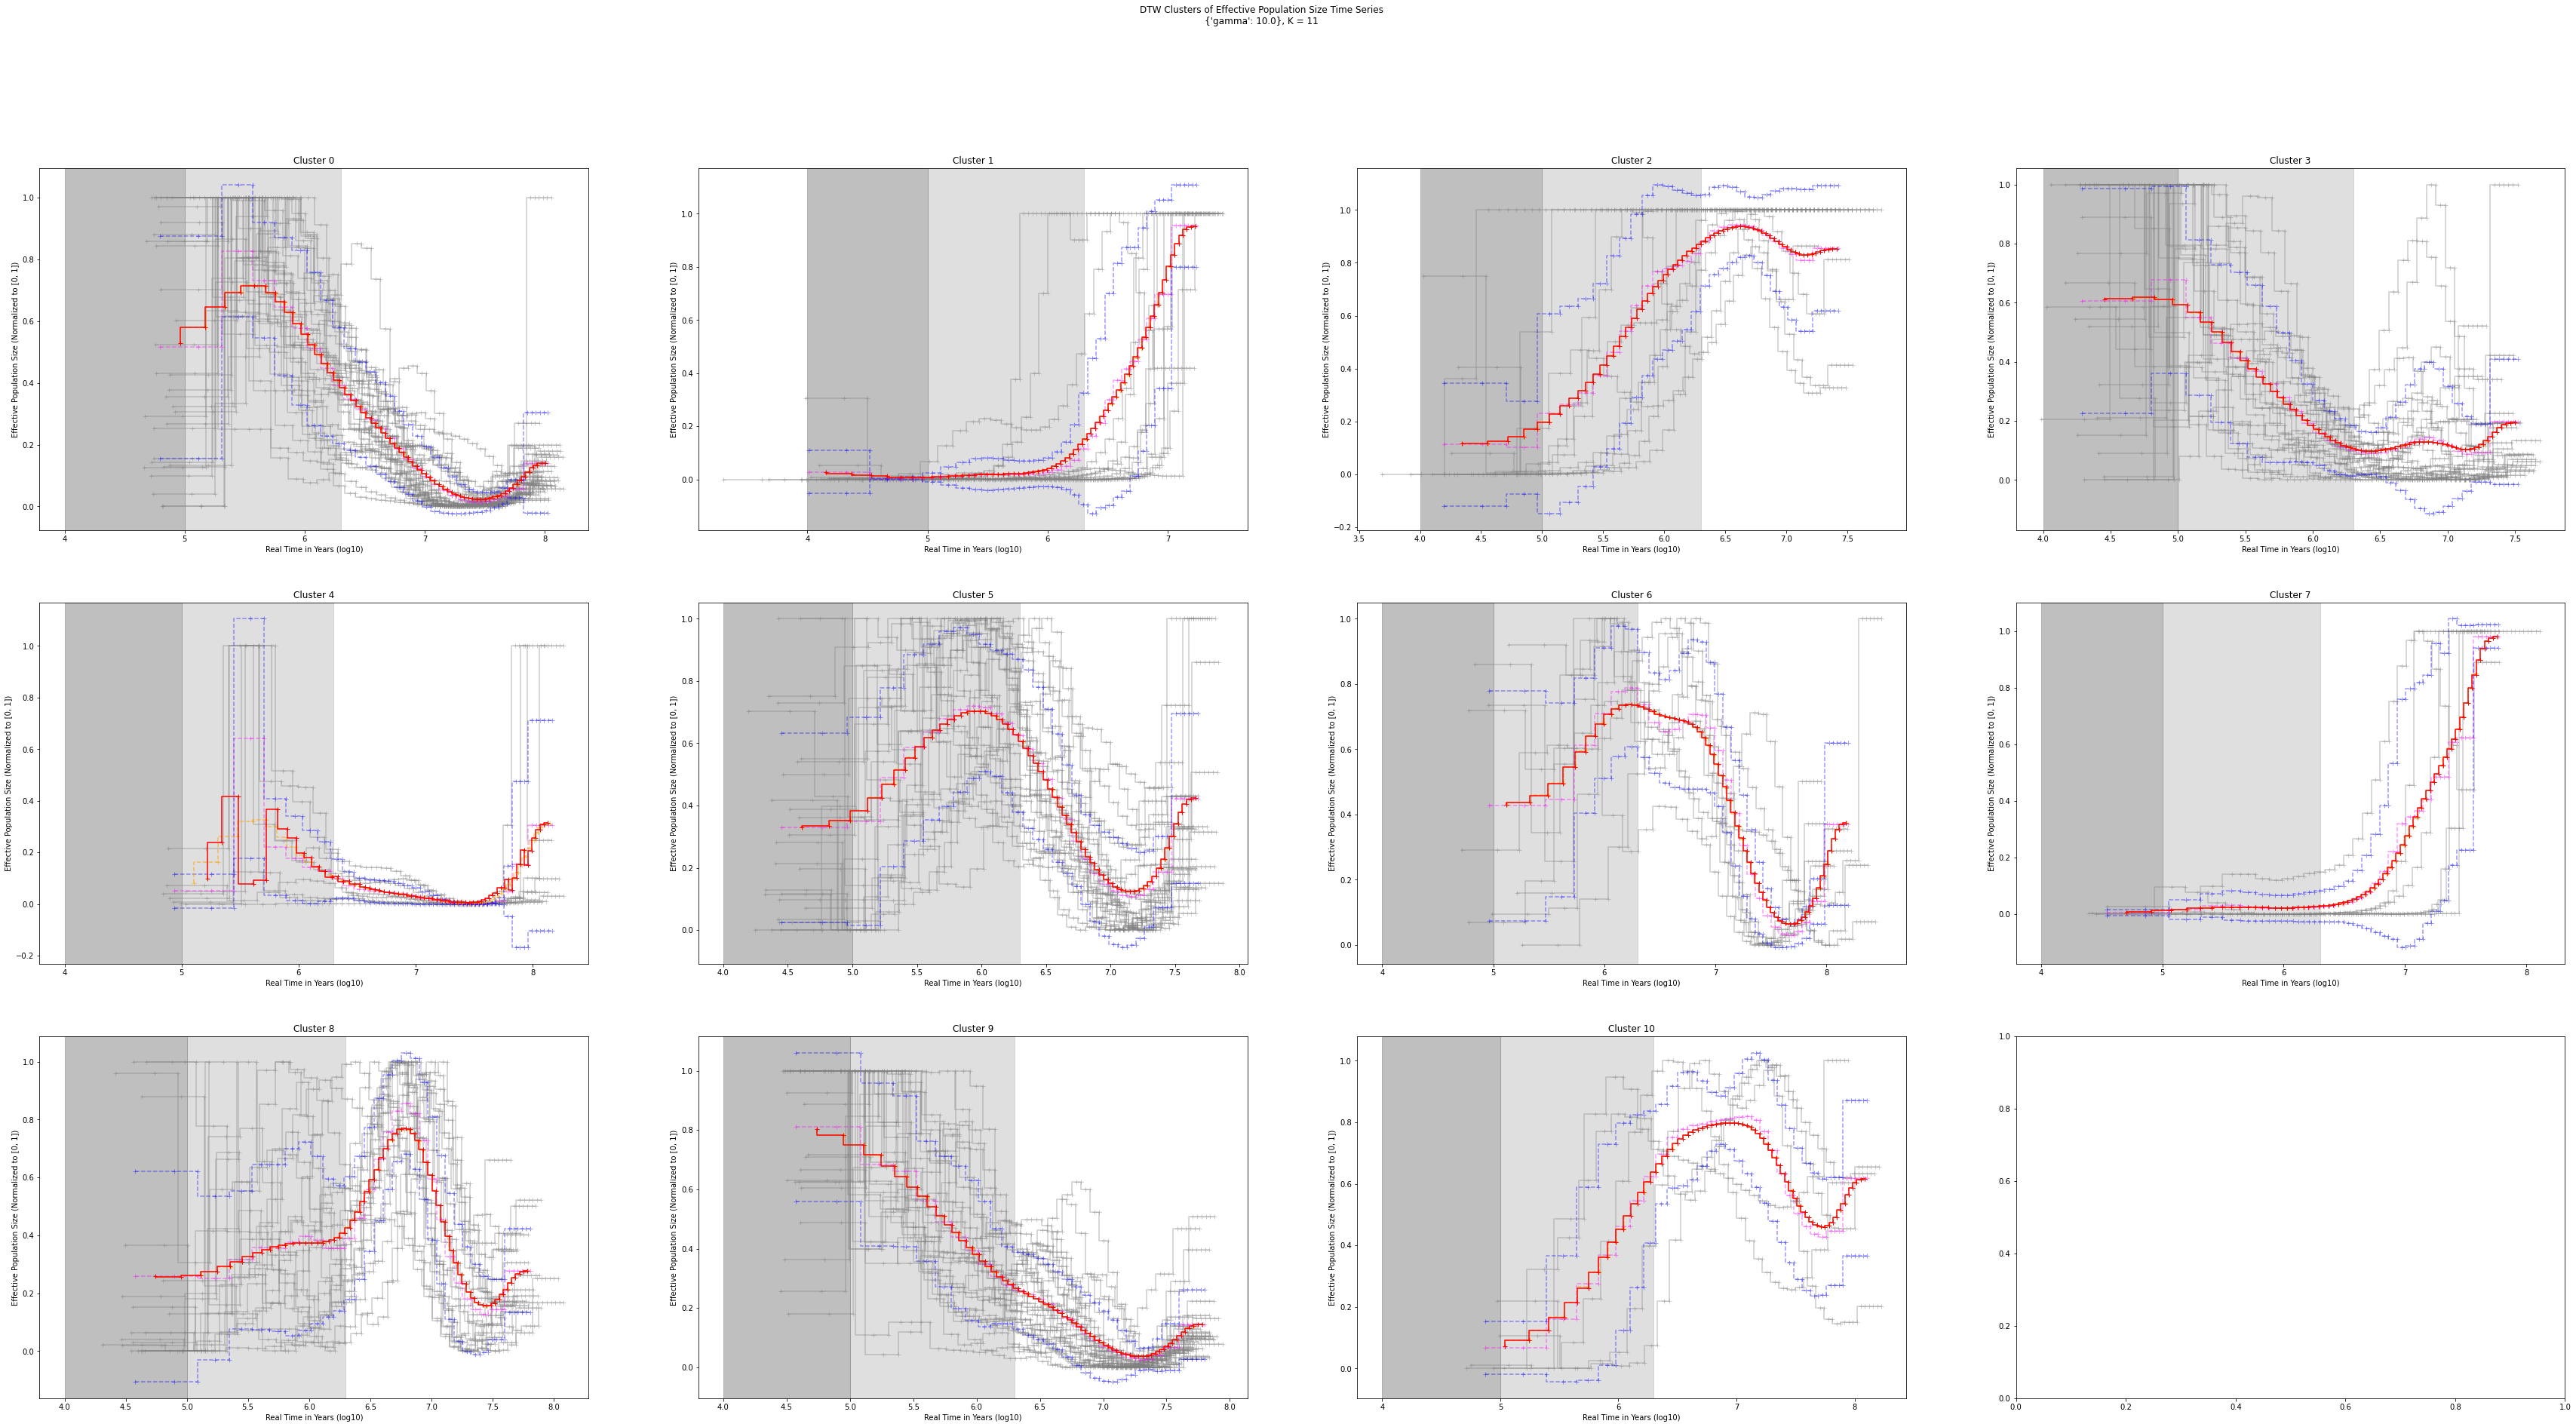

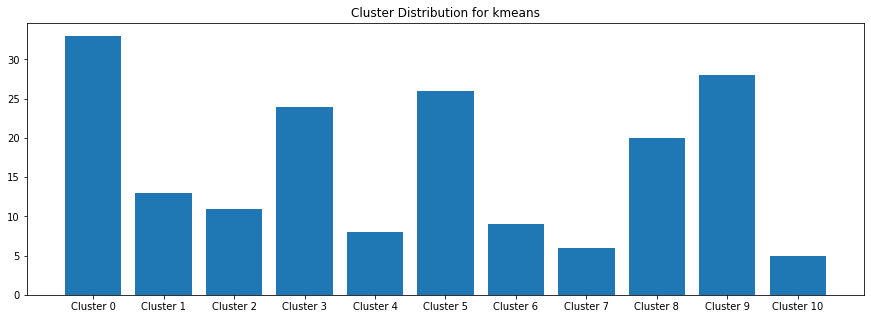

avg_silhouette_score = 0.22307671689160602


In [ ]:
'''
Best clustering method with more lenient filtering

- Might want to check to see if the samples in heavily skewed curves have some
    sort of historical or geographical barriers
    - Maybe a choropleth scatterplot where samples are dots colored by clusters 
        - Doable with longitude/latitude data
        - Then maybe see if placement of samples on map is Stat sig???
        - Funny thing: Might be able to do an animated time series choropleth 
            using varying pop sizes
'''
figures_path = "MSMC-Exploratory-Analysis/results/figures/"
kmeans_name = "kshapes_clustering.png"

cluster_rt_norm_lenient = Msmc_clustering(directory="msmc_curve_data/", 
                                          mu=1.4e-9, 
                                          generation_time_path='generation_lengths/', 
                                          real_time=True, 
                                          to_omit=omit_test_lenient, 
                                          normalize_lambda=True, 
                                          log_scale_time=True, 
                                          plot_on_log_scale=True, 
                                          exclude_subdirs=["Archive", "mammals_part_1"], 
                                          manual_cluster_count=11,
                                          algo="kmeans") # cluster count by sqrt method is 14

cluster_rt_norm_lenient.cluster_curves(omit_front=0, 
                                       omit_back=0, 
                                       cols=4,  
                                       fs_x=60, 
                                       fs_y=30,
                                       metric_params={"gamma" : 10.0})
# Save curve-cluster table
# alt_path2 = "MSMC-Exploratory-Analysis/results/lists/"
# cluster_rt_norm_lenient.clusterTable.to_csv(alt_path2+"curve-cluster-table.tsv", sep="\t")
# Comment out elbow method part if not needed, it takes forever 
# cluster_rt_norm_lenient.elbow_method()

'''
Silhouette score 
'''
from tslearn.generators import random_walks
from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score

X = np.array([i.drop("right_time_boundary", axis=1).to_numpy() for i in cluster_rt_norm_lenient.mySeries])
labels = cluster_rt_norm_lenient.dtw_labels
avg_silhouette_score = silhouette_score(X, labels, metric = 'softdtw')
print(f"avg_silhouette_score = {avg_silhouette_score}")

In [ ]:
cluster_rt_norm_lenient.km.inertia_

2.2519428619921573

# Inertia + Silhouette Score Plots 
- Align vertically (Inertia on top)
- X-axis will be cluster numbers (In common)

## Inertias
- Y-axis will be Within Group SSE (Inertia) 

## Silhouette Scores
- Y-axis will be Silhouette Score

# Distance Matrix Analysis

- Using default settings to analyze distance matrix created
- NOTE: Clustering is not required, just read in time series data and send it 
with the `soft_dtw()` function

In [ ]:
clustering = Msmc_clustering(directory="msmc_curve_data/", 
                                          mu=1.4e-9, 
                                          generation_time_path='generation_lengths/', 
                                          real_time=True, 
                                          to_omit=omit_test_lenient, 
                                          normalize_lambda=True, 
                                          log_scale_time=True, 
                                          plot_on_log_scale=True, 
                                          exclude_subdirs=["Archive", "mammals_part_1"], 
                                          manual_cluster_count=9,
                                          algo="kmeans") # cluster count by sqrt method is 14

fileLen: 11126
duplicate entries: 0
fileLen: 7
duplicate entries: 0


In [ ]:
# Initialize distance matrix
# Normalize the curves
from tslearn.metrics import soft_dtw 
names = clustering.namesofMySeries
data = clustering.mySeries # For clustered models can use clustering.clustering_data

distance_matrix = np.zeros((len(data), len(data)))
for idx, i in enumerate(data):
    for jdx, j in enumerate(data):
        # Calculate pairwise distances using dynamic time warping
        distance  = soft_dtw(i.drop(labels=["right_time_boundary"], axis=1).to_numpy(), 
                             j.drop(labels=["right_time_boundary"], axis=1).to_numpy(), gamma=0)
        distance_matrix[idx][jdx] = distance
        distance_matrix[jdx][idx] = distance
print(distance_matrix)

[[ 0.         11.27524441  8.54365123 ...  9.79234107 10.11890365
   2.58574477]
 [11.27524441  0.         24.22482295 ...  7.59321444  4.05346456
   7.17869708]
 [ 8.54365123 24.22482295  0.         ... 26.29697856 22.99600253
   9.02007577]
 ...
 [ 9.79234107  7.59321444 26.29697856 ...  0.          9.94374016
   6.12901534]
 [10.11890365  4.05346456 22.99600253 ...  9.94374016  0.
   7.49137957]
 [ 2.58574477  7.17869708  9.02007577 ...  6.12901534  7.49137957
   0.        ]]


In [ ]:
DF = pd.DataFrame(distance_matrix)
DF
# save the dataframe as a csv file
DF.to_csv(silhouette_path+"distance_matrix_c_num_is_9.csv")

In [ ]:
DF = pd.DataFrame(names)
DF
# save the dataframe as a csv file
DF.to_csv(silhouette_path+"ordered_names_for_distance_matrix_c_num_is_9.csv")

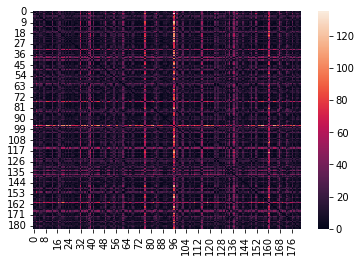

In [ ]:
sns.heatmap(distance_matrix)

In [ ]:
distance_matrix.argmax(axis=1)

array([ 96,  96,  96,  96,  96,  96,  96, 161,  96,  96,  96,  96,  96,
       161,  96,  96,  96,  96, 161,  96,  96,  96,  96,  96,  96,  96,
        96,  96,  96,  96,  96,  96,   2,  96,  96,  96, 137,  96,   2,
       119,  96, 119,  96,  96,  96,  96, 149,  96, 161,   2,  96,  96,
        96,  96, 161, 161,  96,  96, 149,  96,  96,   2, 161,  96,  96,
       149,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,   2,  96,
        96,  96,  96,  96,  96,  96,   2,  96,  96,  96,  96,  96, 161,
        96,  96,  96,  96,  96,   2,  96,   2,  96,  96,  96,  96,  96,
        96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96, 119,  96,
        96,  96,  96,  96,  96,  96,  96, 161, 161, 161,  96,  96, 161,
        96,  82,  96,  96,  44,  96, 119, 119,  96,   2,  96,  96,  96,
         2,  96,  96,  96,  96, 161, 161,  96,  96,   2, 161,  96,  96,
        96,  96,  96,  96,  96, 119,  96,  96,  96,  96,  96,  96,  82,
       161,  96,  96,  96,  96,  96,  96,  96, 161,  96,  96,  9